In [ ]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/M.Learning/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
TRAINING_DIR = "./train"
VALIDATION_DIR = "./test"
# Thư mục training with_mask 
train_with_mask_dir = os.path.join(TRAINING_DIR, 'with_mask')

# Thư mục training without_mask
train_without_mask_dir = os.path.join(TRAINING_DIR, 'without_mask')

# Thư mục validation with_mask 
vali_with_mask_dir = os.path.join(VALIDATION_DIR, 'with_mask')

# Thư mục validation without_mask 
vali_without_mask_dir = os.path.join(VALIDATION_DIR, 'without_mask')

Xem 10 phần tử trong tập train (with_mask và without_mask)


In [ ]:
train_with_mask_fnames = os.listdir(train_with_mask_dir)
print(train_with_mask_fnames[:10])

train_without_mask_fnames = os.listdir(train_without_mask_dir)
print(train_without_mask_fnames[:10])

['4-with-mask.jpg', 'augmented_image_181.jpg', 'image.jpg', '481-with-mask.jpg', 'augmented_image_42.jpg', '61XjbVDoxKL--AC-SL1500-.jpg', 'augmented_image_3.jpg', '397-with-mask.jpg', '119-with-mask.jpg', 'augmented_image_234.jpg']
['want-to-see-more-indian-faces-in-us-government-raj-mukherji.jpg', 'augmented_image_318.jpg', '4.jpg', 'augmented_image_302.jpg', '156.jpg', '108.jpg', '110.jpg', '287.jpg', 'augmented_image_224.jpg', 'augmented_image_255.jpg']


Xem tổng số ảnh trong tập training

In [ ]:
print('Tổng số ảnh train with_mask: ', len(os.listdir(train_with_mask_dir)))
print('Tổng số ảnh train without_mask: ', len(os.listdir(train_without_mask_dir)))
print('Tổng số ảnh validation with_mask: ', len(os.listdir(vali_with_mask_dir)))
print('Tổng số ảnh validation without_mask: ', len(os.listdir(vali_without_mask_dir)))

Tổng số ảnh train with_mask:  658
Tổng số ảnh train without_mask:  674
Tổng số ảnh validation with_mask:  97
Tổng số ảnh validation without_mask:  97


Cấu hình tham số matplotlib

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Một số hình ảnh minh họa

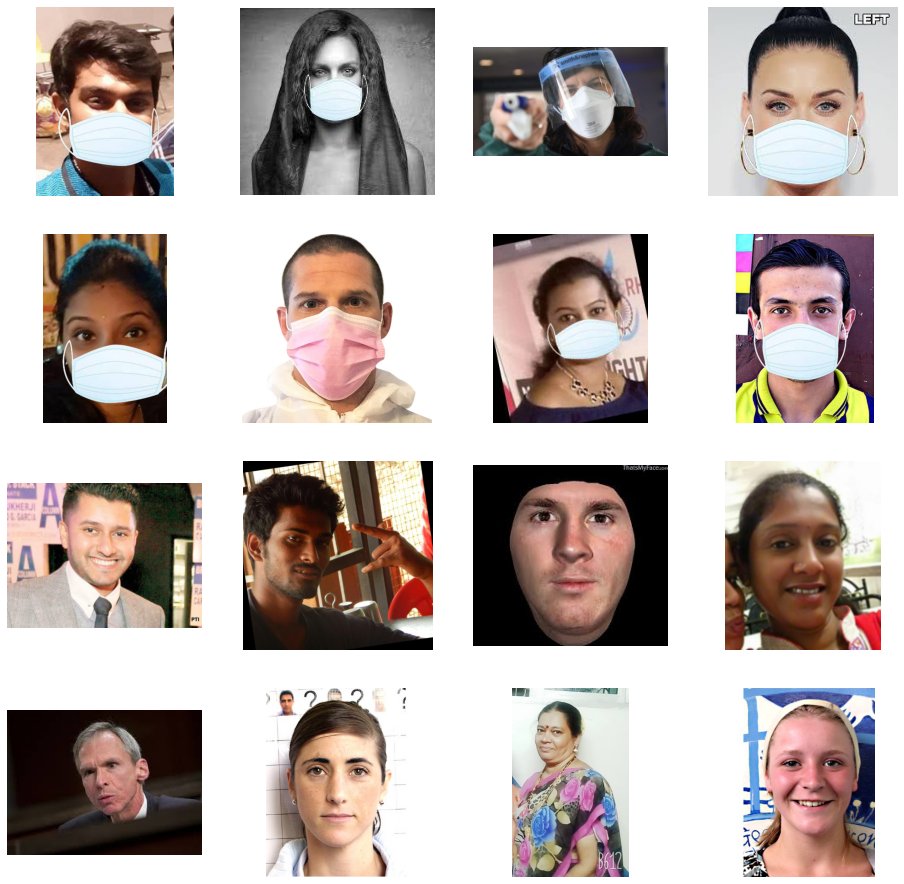

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_with_mask_pix = [os.path.join(train_with_mask_dir, fname) 
                for fname in train_with_mask_fnames[pic_index-8:pic_index]]
next_without_mask_pix = [os.path.join(train_without_mask_dir, fname) 
                for fname in train_without_mask_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_with_mask_pix + next_without_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
model =Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    #Conv2D(100, (3,3), activation='sigmoid'),
    #MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Tiền xử lý dữ liệu - Data Preprocessing

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=20, 
                                                    target_size=(150, 150))

Found 1332 images belonging to 2 classes.


In [ ]:
# All images will be rescaled by 1./255
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow validation images in batches of 10 using val_datagen generator
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=20, 
                                                         target_size=(150, 150))

Found 194 images belonging to 2 classes.


Training - Tạo model

In [ ]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history = model.fit_generator(train_generator,
                              epochs=3,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/3
67/67 [==============================] - 333s 5s/step - loss: 0.5655 - acc: 0.6847 - val_loss: 0.2329 - val_acc: 0.9072
Epoch 2/3
67/67 [==============================] - 142s 2s/step - loss: 0.4218 - acc: 0.8521 - val_loss: 0.2244 - val_acc: 0.9433
Epoch 3/3
67/67 [==============================] - 146s 2s/step - loss: 0.3295 - acc: 0.8836 - val_loss: 0.1485 - val_acc: 0.9485


Visualizing Intermediate Representations